In [1]:
import endomill
import yaml


In [2]:
parameter_packs = [
    {
        "MILL_FITNESS_ADVANTAGE": fitness_advantage,
        "MILL_REPLICATE": replicate,
    }
    for replicate in range(10)
    for fitness_advantage in [0.0, 0.1, 1.0]
]

for i, pp in enumerate(parameter_packs):
    with open(
        f"gene-selection-inference-parameterization-{i}.yaml", "w"
    ) as file:
        yaml.safe_dump(pp, file)
# endomill.instantiate_over(parameter_packs=parameter_packs)


# Papermill Parameters


In [3]:
MILL_FITNESS_ADVANTAGE: float
MILL_REPLICATE: int


In [4]:
# Parameters
MILL_FITNESS_ADVANTAGE = 0.1
MILL_REPLICATE = 4


In [5]:
import copy
import random

import alifedata_phyloinformatics_convert as apc
from deap import algorithms as deap_algorithms
from deap import base as deap_base
from deap import creator as deap_creator
from deap import tools as deap_tools
from hstrat import hstrat
from keyname import keyname as kn
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from teeplot import teeplot as tp
from tqdm import tqdm

import pylib


In [6]:
random.seed(MILL_REPLICATE)


# Parameters


In [7]:
HSTRAT_RESOLUTION = 1000
HSTRAT_DIFFERENTIA_WIDTH = 64

TOURNAMENT_SIZE = 2

NGEN = 200

POPULATION_SIZE = 400


# Setup


In [8]:
deap_creator.create("FitnessMax", deap_base.Fitness, weights=(1.0,))
deap_creator.create("Individual", list, fitness=deap_creator.FitnessMax)

toolbox = deap_base.Toolbox()

toolbox.register(
    "individual",
    lambda *args, **kwargs: deap_creator.Individual([0.0]),
    deap_creator.Individual,
    n=1,
)
toolbox.register("population", deap_tools.initRepeat, list, toolbox.individual)


def evalOneMax(individual):
    return (individual[0] + random.random(),)


toolbox.register("evaluate", evalOneMax)
# hack to ensure gene annotation remains associated with gene
toolbox.register("mate", lambda x, y: random.choice([(x, y), (y, x)]))
toolbox.register("mutate", lambda x: tuple(x))
toolbox.register("select", deap_tools.selTournament, tournsize=TOURNAMENT_SIZE)

# Decorate the variation operators
toolbox.decorate("mate", pylib.deap.hstrat_mate_decorator)


# Evolve


In [9]:
# Create the population and populate the history
population = toolbox.population(n=POPULATION_SIZE)

species_ancestor = hstrat.HereditaryStratigraphicColumn(
    stratum_retention_policy=hstrat.nominal_resolution_algo.Policy(),
    stratum_differentia_bit_width=HSTRAT_DIFFERENTIA_WIDTH,
)
for member in population:
    member.species_annotation = species_ancestor.CloneDescendant()
    member.gene_annotation = hstrat.HereditaryStratigraphicColumn(
        stratum_retention_policy=hstrat.perfect_resolution_algo.Policy(),
        stratum_differentia_bit_width=HSTRAT_DIFFERENTIA_WIDTH,
        initial_stratum_annotation=0,
    ).CloneDescendant(0)


# Do the evolution, the decorators will take care of updating the
# history
prevalences = []
for gen in tqdm(range(NGEN)):
    prevalences.append(sum(1 for x in population if x[0] > 0))

    offspring = deap_algorithms.varAnd(
        population, toolbox, cxpb=1.0, mutpb=0.0
    )
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))
    population = [copy.deepcopy(ind) for ind in population]

    if gen >= NGEN // 4:
        if prevalences[-1] == 0:
            population[0][0] = MILL_FITNESS_ADVANTAGE



  0%|                                                                                                                                                                 | 0/200 [00:00<?, ?it/s]

  0%|▊                                                                                                                                                        | 1/200 [00:02<06:40,  2.01s/it]

  1%|█▌                                                                                                                                                       | 2/200 [00:04<06:40,  2.02s/it]

  2%|██▎                                                                                                                                                      | 3/200 [00:05<05:21,  1.63s/it]

  2%|███                                                                                                                                                      | 4/200 [00:06<05:22,  1.65s/it]

  2%|███▊                                                                                                                                                     | 5/200 [00:08<05:22,  1.65s/it]

  3%|████▌                                                                                                                                                    | 6/200 [00:10<05:26,  1.69s/it]

  4%|█████▎                                                                                                                                                   | 7/200 [00:11<05:08,  1.60s/it]

  4%|██████                                                                                                                                                   | 8/200 [00:13<05:10,  1.62s/it]

  4%|██████▉                                                                                                                                                  | 9/200 [00:14<05:05,  1.60s/it]

  5%|███████▌                                                                                                                                                | 10/200 [00:16<05:05,  1.61s/it]

  6%|████████▎                                                                                                                                               | 11/200 [00:18<04:56,  1.57s/it]

  6%|█████████                                                                                                                                               | 12/200 [00:19<05:04,  1.62s/it]

  6%|█████████▉                                                                                                                                              | 13/200 [00:21<05:07,  1.64s/it]

  7%|██████████▋                                                                                                                                             | 14/200 [00:23<05:19,  1.72s/it]

  8%|███████████▍                                                                                                                                            | 15/200 [00:25<05:50,  1.89s/it]

  8%|████████████▏                                                                                                                                           | 16/200 [00:27<06:03,  1.98s/it]

  8%|████████████▉                                                                                                                                           | 17/200 [00:29<05:54,  1.94s/it]

  9%|█████████████▋                                                                                                                                          | 18/200 [00:31<05:48,  1.91s/it]

 10%|██████████████▍                                                                                                                                         | 19/200 [00:33<05:55,  1.96s/it]

 10%|███████████████▏                                                                                                                                        | 20/200 [00:35<05:32,  1.85s/it]

 10%|███████████████▉                                                                                                                                        | 21/200 [00:37<05:36,  1.88s/it]

 11%|████████████████▋                                                                                                                                       | 22/200 [00:39<06:19,  2.13s/it]

 12%|█████████████████▍                                                                                                                                      | 23/200 [00:42<06:45,  2.29s/it]

 12%|██████████████████▏                                                                                                                                     | 24/200 [00:45<07:05,  2.42s/it]

 12%|███████████████████                                                                                                                                     | 25/200 [00:47<07:04,  2.43s/it]

 13%|███████████████████▊                                                                                                                                    | 26/200 [00:51<07:50,  2.70s/it]

 14%|████████████████████▌                                                                                                                                   | 27/200 [00:54<08:01,  2.78s/it]

 14%|█████████████████████▎                                                                                                                                  | 28/200 [00:57<08:36,  3.00s/it]

 14%|██████████████████████                                                                                                                                  | 29/200 [00:59<07:48,  2.74s/it]

 15%|██████████████████████▊                                                                                                                                 | 30/200 [01:03<08:27,  2.99s/it]

 16%|███████████████████████▌                                                                                                                                | 31/200 [01:06<08:40,  3.08s/it]

 16%|████████████████████████▎                                                                                                                               | 32/200 [01:09<08:53,  3.17s/it]

 16%|█████████████████████████                                                                                                                               | 33/200 [01:12<08:19,  2.99s/it]

 17%|█████████████████████████▊                                                                                                                              | 34/200 [01:15<08:27,  3.05s/it]

 18%|██████████████████████████▌                                                                                                                             | 35/200 [01:18<08:32,  3.11s/it]

 18%|███████████████████████████▎                                                                                                                            | 36/200 [01:22<08:43,  3.19s/it]

 18%|████████████████████████████                                                                                                                            | 37/200 [01:25<08:32,  3.15s/it]

 19%|████████████████████████████▉                                                                                                                           | 38/200 [01:28<08:35,  3.18s/it]

 20%|█████████████████████████████▋                                                                                                                          | 39/200 [01:32<08:54,  3.32s/it]

 20%|██████████████████████████████▍                                                                                                                         | 40/200 [01:35<08:29,  3.18s/it]

 20%|███████████████████████████████▏                                                                                                                        | 41/200 [01:37<08:07,  3.06s/it]

 21%|███████████████████████████████▉                                                                                                                        | 42/200 [01:41<08:09,  3.10s/it]

 22%|████████████████████████████████▋                                                                                                                       | 43/200 [01:44<08:33,  3.27s/it]

 22%|█████████████████████████████████▍                                                                                                                      | 44/200 [01:49<09:17,  3.58s/it]

 22%|██████████████████████████████████▏                                                                                                                     | 45/200 [01:52<08:52,  3.44s/it]

 23%|██████████████████████████████████▉                                                                                                                     | 46/200 [01:55<09:00,  3.51s/it]

 24%|███████████████████████████████████▋                                                                                                                    | 47/200 [01:59<08:56,  3.51s/it]

 24%|████████████████████████████████████▍                                                                                                                   | 48/200 [02:03<09:31,  3.76s/it]

 24%|█████████████████████████████████████▏                                                                                                                  | 49/200 [02:07<09:15,  3.68s/it]

 25%|██████████████████████████████████████                                                                                                                  | 50/200 [02:11<09:43,  3.89s/it]

 26%|██████████████████████████████████████▊                                                                                                                 | 51/200 [02:15<09:29,  3.82s/it]

 26%|███████████████████████████████████████▌                                                                                                                | 52/200 [02:18<09:00,  3.65s/it]

 26%|████████████████████████████████████████▎                                                                                                               | 53/200 [02:22<09:13,  3.76s/it]

 27%|█████████████████████████████████████████                                                                                                               | 54/200 [02:26<09:09,  3.76s/it]

 28%|█████████████████████████████████████████▊                                                                                                              | 55/200 [02:30<09:31,  3.94s/it]

 28%|██████████████████████████████████████████▌                                                                                                             | 56/200 [02:34<09:39,  4.02s/it]

 28%|███████████████████████████████████████████▎                                                                                                            | 57/200 [02:38<09:25,  3.96s/it]

 29%|████████████████████████████████████████████                                                                                                            | 58/200 [02:42<09:19,  3.94s/it]

 30%|████████████████████████████████████████████▊                                                                                                           | 59/200 [02:46<09:05,  3.87s/it]

 30%|█████████████████████████████████████████████▌                                                                                                          | 60/200 [02:49<08:34,  3.68s/it]

 30%|██████████████████████████████████████████████▎                                                                                                         | 61/200 [02:53<08:48,  3.80s/it]

 31%|███████████████████████████████████████████████                                                                                                         | 62/200 [02:58<09:15,  4.02s/it]

 32%|███████████████████████████████████████████████▉                                                                                                        | 63/200 [03:02<09:13,  4.04s/it]

 32%|████████████████████████████████████████████████▋                                                                                                       | 64/200 [03:06<09:07,  4.03s/it]

 32%|█████████████████████████████████████████████████▍                                                                                                      | 65/200 [03:11<09:53,  4.40s/it]

 33%|██████████████████████████████████████████████████▏                                                                                                     | 66/200 [03:15<09:39,  4.32s/it]

 34%|██████████████████████████████████████████████████▉                                                                                                     | 67/200 [03:20<10:11,  4.60s/it]

 34%|███████████████████████████████████████████████████▋                                                                                                    | 68/200 [03:24<09:20,  4.25s/it]

 34%|████████████████████████████████████████████████████▍                                                                                                   | 69/200 [03:28<09:09,  4.19s/it]

 35%|█████████████████████████████████████████████████████▏                                                                                                  | 70/200 [03:33<09:38,  4.45s/it]

 36%|█████████████████████████████████████████████████████▉                                                                                                  | 71/200 [03:37<09:39,  4.49s/it]

 36%|██████████████████████████████████████████████████████▋                                                                                                 | 72/200 [03:42<09:29,  4.45s/it]

 36%|███████████████████████████████████████████████████████▍                                                                                                | 73/200 [03:46<09:09,  4.33s/it]

 37%|████████████████████████████████████████████████████████▏                                                                                               | 74/200 [03:52<10:03,  4.79s/it]

 38%|█████████████████████████████████████████████████████████                                                                                               | 75/200 [03:57<10:34,  5.08s/it]

 38%|█████████████████████████████████████████████████████████▊                                                                                              | 76/200 [04:02<09:59,  4.84s/it]

 38%|██████████████████████████████████████████████████████████▌                                                                                             | 77/200 [04:07<10:21,  5.05s/it]

 39%|███████████████████████████████████████████████████████████▎                                                                                            | 78/200 [04:12<10:00,  4.92s/it]

 40%|████████████████████████████████████████████████████████████                                                                                            | 79/200 [04:18<10:37,  5.27s/it]

 40%|████████████████████████████████████████████████████████████▊                                                                                           | 80/200 [04:23<10:32,  5.27s/it]

 40%|█████████████████████████████████████████████████████████████▌                                                                                          | 81/200 [04:29<10:37,  5.35s/it]

 41%|██████████████████████████████████████████████████████████████▎                                                                                         | 82/200 [04:34<10:19,  5.25s/it]

 42%|███████████████████████████████████████████████████████████████                                                                                         | 83/200 [04:38<09:45,  5.00s/it]

 42%|███████████████████████████████████████████████████████████████▊                                                                                        | 84/200 [04:44<09:53,  5.12s/it]

 42%|████████████████████████████████████████████████████████████████▌                                                                                       | 85/200 [04:49<09:52,  5.15s/it]

 43%|█████████████████████████████████████████████████████████████████▎                                                                                      | 86/200 [04:54<09:55,  5.22s/it]

 44%|██████████████████████████████████████████████████████████████████                                                                                      | 87/200 [05:00<10:04,  5.35s/it]

 44%|██████████████████████████████████████████████████████████████████▉                                                                                     | 88/200 [05:04<09:23,  5.03s/it]

 44%|███████████████████████████████████████████████████████████████████▋                                                                                    | 89/200 [05:09<09:01,  4.88s/it]

 45%|████████████████████████████████████████████████████████████████████▍                                                                                   | 90/200 [05:14<09:06,  4.97s/it]

 46%|█████████████████████████████████████████████████████████████████████▏                                                                                  | 91/200 [05:19<09:14,  5.09s/it]

 46%|█████████████████████████████████████████████████████████████████████▉                                                                                  | 92/200 [05:25<09:39,  5.36s/it]

 46%|██████████████████████████████████████████████████████████████████████▋                                                                                 | 93/200 [05:31<10:02,  5.63s/it]

 47%|███████████████████████████████████████████████████████████████████████▍                                                                                | 94/200 [05:37<09:54,  5.61s/it]

 48%|████████████████████████████████████████████████████████████████████████▏                                                                               | 95/200 [05:42<09:30,  5.43s/it]

 48%|████████████████████████████████████████████████████████████████████████▉                                                                               | 96/200 [05:47<09:17,  5.36s/it]

 48%|█████████████████████████████████████████████████████████████████████████▋                                                                              | 97/200 [05:53<09:19,  5.43s/it]

 49%|██████████████████████████████████████████████████████████████████████████▍                                                                             | 98/200 [05:58<09:08,  5.37s/it]

 50%|███████████████████████████████████████████████████████████████████████████▏                                                                            | 99/200 [06:03<08:59,  5.34s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 100/200 [06:09<08:52,  5.32s/it]

 50%|████████████████████████████████████████████████████████████████████████████▎                                                                          | 101/200 [06:14<08:49,  5.35s/it]

 51%|█████████████████████████████████████████████████████████████████████████████                                                                          | 102/200 [06:20<09:02,  5.54s/it]

 52%|█████████████████████████████████████████████████████████████████████████████▊                                                                         | 103/200 [06:26<09:12,  5.69s/it]

 52%|██████████████████████████████████████████████████████████████████████████████▌                                                                        | 104/200 [06:32<09:11,  5.75s/it]

 52%|███████████████████████████████████████████████████████████████████████████████▎                                                                       | 105/200 [06:38<09:15,  5.85s/it]

 53%|████████████████████████████████████████████████████████████████████████████████                                                                       | 106/200 [06:43<08:49,  5.64s/it]

 54%|████████████████████████████████████████████████████████████████████████████████▊                                                                      | 107/200 [06:49<08:51,  5.72s/it]

 54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                     | 108/200 [06:56<09:14,  6.03s/it]

 55%|██████████████████████████████████████████████████████████████████████████████████▎                                                                    | 109/200 [07:01<08:55,  5.88s/it]

 55%|███████████████████████████████████████████████████████████████████████████████████                                                                    | 110/200 [07:07<08:36,  5.74s/it]

 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                   | 111/200 [07:14<09:02,  6.09s/it]

 56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 112/200 [07:20<08:57,  6.10s/it]

 56%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 113/200 [07:25<08:36,  5.94s/it]

 57%|██████████████████████████████████████████████████████████████████████████████████████                                                                 | 114/200 [07:31<08:20,  5.82s/it]

 57%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                | 115/200 [07:37<08:13,  5.81s/it]

 58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                               | 116/200 [07:43<08:30,  6.07s/it]

 58%|████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 117/200 [07:49<08:23,  6.06s/it]

 59%|█████████████████████████████████████████████████████████████████████████████████████████                                                              | 118/200 [07:55<08:08,  5.95s/it]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 119/200 [08:02<08:17,  6.14s/it]

 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 120/200 [08:08<08:12,  6.15s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 121/200 [08:14<08:06,  6.15s/it]

 61%|████████████████████████████████████████████████████████████████████████████████████████████                                                           | 122/200 [08:21<08:12,  6.31s/it]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 123/200 [08:27<07:59,  6.23s/it]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 124/200 [08:33<07:56,  6.27s/it]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 125/200 [08:41<08:27,  6.76s/it]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 126/200 [08:47<08:08,  6.60s/it]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 127/200 [08:54<07:59,  6.57s/it]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 128/200 [09:00<07:49,  6.53s/it]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 129/200 [09:07<07:42,  6.52s/it]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 130/200 [09:14<07:46,  6.67s/it]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 131/200 [09:21<07:45,  6.74s/it]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 132/200 [09:28<07:50,  6.92s/it]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 133/200 [09:35<07:42,  6.90s/it]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 134/200 [09:42<07:38,  6.95s/it]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 135/200 [09:48<07:21,  6.80s/it]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 136/200 [09:55<07:21,  6.89s/it]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 137/200 [10:03<07:19,  6.97s/it]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 138/200 [10:10<07:21,  7.12s/it]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 139/200 [10:16<06:56,  6.83s/it]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 140/200 [10:23<06:44,  6.74s/it]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 141/200 [10:31<07:02,  7.16s/it]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 142/200 [10:38<06:56,  7.18s/it]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 143/200 [10:45<06:36,  6.96s/it]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 144/200 [10:51<06:24,  6.87s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 145/200 [11:00<06:47,  7.41s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 146/200 [11:07<06:32,  7.27s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 147/200 [11:17<07:14,  8.19s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 148/200 [11:25<06:52,  7.94s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 149/200 [11:32<06:42,  7.89s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 150/200 [11:40<06:27,  7.74s/it]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 151/200 [11:48<06:23,  7.83s/it]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 152/200 [11:55<06:04,  7.60s/it]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 153/200 [12:02<05:51,  7.48s/it]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 154/200 [12:10<05:53,  7.68s/it]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 155/200 [12:17<05:38,  7.53s/it]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 156/200 [12:25<05:28,  7.47s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 157/200 [12:33<05:31,  7.70s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 158/200 [12:41<05:22,  7.68s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 159/200 [12:50<05:32,  8.12s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 160/200 [12:57<05:15,  7.88s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 161/200 [13:05<05:08,  7.91s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 162/200 [13:13<04:57,  7.84s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 163/200 [13:20<04:46,  7.73s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 164/200 [13:27<04:32,  7.57s/it]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 165/200 [13:34<04:18,  7.37s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 166/200 [13:43<04:25,  7.82s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 167/200 [13:51<04:19,  7.87s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 168/200 [13:59<04:09,  7.78s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 169/200 [14:06<03:53,  7.53s/it]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 170/200 [14:14<03:53,  7.78s/it]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 171/200 [14:22<03:43,  7.71s/it]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 172/200 [14:31<03:47,  8.11s/it]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 173/200 [14:38<03:35,  8.00s/it]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 174/200 [14:46<03:26,  7.95s/it]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 175/200 [14:55<03:25,  8.20s/it]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 176/200 [15:03<03:15,  8.14s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 177/200 [15:11<03:04,  8.02s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 178/200 [15:20<03:03,  8.33s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 179/200 [15:28<02:53,  8.26s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 180/200 [15:36<02:45,  8.28s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 181/200 [15:44<02:36,  8.24s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 182/200 [15:53<02:30,  8.36s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 183/200 [16:01<02:21,  8.32s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 184/200 [16:09<02:09,  8.10s/it]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 185/200 [16:18<02:05,  8.39s/it]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 186/200 [16:27<02:00,  8.59s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 187/200 [16:36<01:53,  8.70s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 188/200 [16:44<01:44,  8.67s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 189/200 [16:52<01:33,  8.46s/it]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 190/200 [17:01<01:25,  8.56s/it]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 191/200 [17:10<01:17,  8.64s/it]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 192/200 [17:19<01:08,  8.61s/it]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 193/200 [17:28<01:01,  8.73s/it]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 194/200 [17:37<00:52,  8.82s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 195/200 [17:45<00:43,  8.75s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 196/200 [17:54<00:35,  8.81s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 197/200 [18:03<00:26,  8.95s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 198/200 [18:13<00:18,  9.21s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 199/200 [18:23<00:09,  9.36s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [18:27<00:00,  7.76s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [18:27<00:00,  5.54s/it]

# Visualization


teeplots/./fitness-advantage=0.1+notebook=gene-selection-inference+replicate=4+viz=plot-sweep-and-annotations+ext=.pdf


teeplots/./fitness-advantage=0.1+notebook=gene-selection-inference+replicate=4+viz=plot-sweep-and-annotations+ext=.png


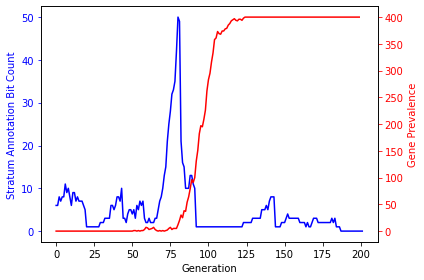

In [10]:
annotations = [
    s.GetAnnotation().bit_count()
    for s in population[0].gene_annotation.IterRetainedStrata()
]


def plot_sweep_and_annotations():
    # Create a figure and a single subplot
    fig, ax1 = plt.subplots()

    # Make the first plot on ax1
    sns.lineplot(data=annotations, color="b", ax=ax1)
    ax1.set_ylabel("Stratum Annotation Bit Count", color="b")
    ax1.tick_params("y", colors="b")

    # Create a second axes that shares the same x-axis
    ax2 = ax1.twinx()

    # Make the second plot on ax2
    sns.lineplot(data=prevalences, color="r", ax=ax2)
    ax2.set_ylabel("Gene Prevalence", color="r")
    ax2.tick_params("y", colors="r")

    ax1.set_xlabel("Generation")

    fig.tight_layout()  # otherwise the right y-label is slightly clipped


tp.tee(
    plot_sweep_and_annotations,
    teeplot_outattrs={
        "notebook": "gene-selection-inference",
        "replicate": str(MILL_REPLICATE),
        "fitness-advantage": str(MILL_FITNESS_ADVANTAGE),
    },
)


In [11]:
records = [
    {
        "notebook": "gene-selection-inference",
        "replicate": MILL_REPLICATE,
        "fitness-advantage": MILL_FITNESS_ADVANTAGE,
        "generation": generation,
        "prevalence": prevalence,
        "annotation": annotation,
    }
    for generation, (prevalence, annotation) in enumerate(
        zip(prevalences, annotations)
    )
]
outdf = pd.DataFrame.from_records(records)
outdf.to_csv(
    kn.pack(
        {
            "a": "prevalence-annotation-by-generation",
            "notebook": "gene-selection-inference",
            "replicate": str(MILL_REPLICATE),
            "fitness-advantage": str(MILL_FITNESS_ADVANTAGE),
            "ext": ".csv",
        }
    )
)
